# Import

In [119]:
import numpy as np
import pandas as pd
from obspy.clients.fdsn import Client
from obspy import read, read_inventory, UTCDateTime
from obspy.signal import PPSD
from obspy.imaging.cm import *
from obspy.clients.fdsn import Client
import matplotlib.pyplot as plt
import os

plt.style.use('default')
client = Client('IRIS')

# Retrieve TEMP data

In [120]:
df = pd.read_csv('twins_calib_0462_02.csv')

for i in range(3, 9):
    new_df = pd.read_csv('twins_calib_046'+ str(i) + '_02.csv')
    df = pd.concat([df, new_df], ignore_index=True)

df['UTC'] = df['UTC'].map(lambda x: UTCDateTime(x).matplotlib_date)
df['LMST'] = df['LMST'].map(lambda x: x[6:])
df['BMY_BASE_ROD_TEMP'] = df['BMY_BASE_ROD_TEMP'].map(lambda x: x - 273)

df[['LMST', 'UTC', 'BMY_BASE_ROD_TEMP']]

,LMST,UTC,BMY_BASE_ROD_TEMP
0,00:00:00.830,18335.916828,-79.876
1,00:00:01.804,18335.916839,-79.691
2,00:00:02.777,18335.916851,-79.845
3,00:00:03.750,18335.916862,-79.839
4,00:00:04.723,18335.916874,-79.743
...,...,...,...
621432,23:59:55.414,18343.109202,-79.015
621433,23:59:56.387,18343.109214,-79.227
621434,23:59:57.360,18343.109225,-79.015
621435,23:59:58.333,18343.109237,-79.189


---
# Get PPSD from seismic raw data (BHU, BHV, BHW)

In [121]:
# Merge daily Mars continuous waveform

def waveform_merge():
    startdate = input("Enter startdate (YYYYMMDD) : ")
    enddate = str(int(input("Enter enddate (YYYYMMDD) : ")) + 1)
    
    mseed_dir = "화성 연속파형_2020_2021" + "/"
    mseed_list = os.listdir(mseed_dir)
    mseed_startformat = "XB.ELYSE.02.BH1." + startdate + "0000.mseed"
    mseed_endformat = "XB.ELYSE.02.BH1." + enddate + "0000.mseed"

    st = read(mseed_dir + mseed_startformat)

    for mseed in mseed_list:
        if int(mseed.split('.')[4][:8]) >= int(startdate) and int(mseed.split('.')[4][:8]) <= int(enddate) - 1:
            merge = read(mseed_dir + mseed)
            st = st + merge
            st.merge(fill_value= 'interpolate')     
        else:
            continue
       
    print(st)

    return st


In [ ]:
st = waveform_merge()

In [ ]:
tr = st[0]

inv = client.get_stations(starttime = UTCDateTime('2020-01-01T00:00:00.000'), endtime = UTCDateTime('2022-01-01T00:00:00.000'), 
                          network='XB', station='ELYSE', location='02', channel='BHU', level='response')

ppsd = PPSD(tr.stats, metadata= inv, skip_on_gaps= True)
ppsd.add(tr)

In [ ]:
# Save merged waveform as mseed format

st.write('XB.ELYSE.02.BH.20200315_20200322.mseed')

---
# Visualization with PPSD

In [ ]:
# Run PPSD to get Power spectral density from continuous waveform and save as npz format
# first ppsd contains all frequencies and second one contains specific frequency (0.3Hz ~ 10Hz)

tr = st[0]

inv = client.get_stations(starttime = UTCDateTime('2020-03-15T00:00:00.000'), endtime = UTCDateTime('2022-03-22T00:00:00.000'), 
                          network='XB', station='ELYSE', location='02', channel='BHU', level='response')

ppsd = PPSD(tr.stats, metadata= inv, skip_on_gaps= True)
ppsd.add(tr)

ppsd2 = PPSD(tr.stats, metadata= inv, period_limits= (1/5.0, 1/0.8), skip_on_gaps= True)
ppsd2.add(tr)


ppsd.save_npz('mars_20200315_20200322_raw.npz')
ppsd2.save_npz('mars_20200315_20200322.npz')

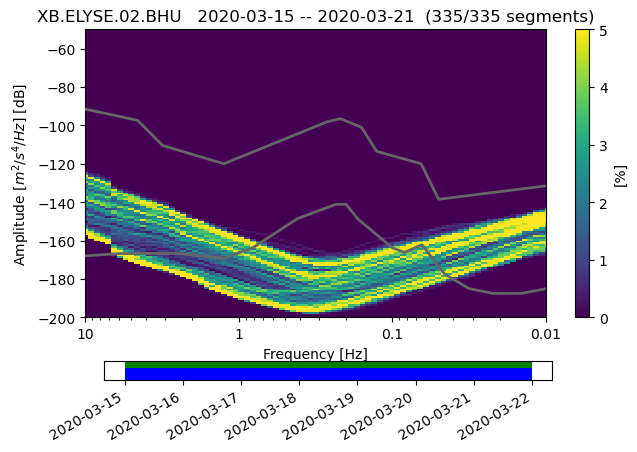

In [122]:
# plot PPSD with all frequencies

example = PPSD.load_npz('mars_20200315_20200322_raw.npz')
example.plot(xaxis_frequency=True, period_lim= (10, 0.01), max_percentage=5, grid=False);

In [ ]:
# plot PPSD with specific freqencies range

example = PPSD.load_npz('mars_20200315_20200322.npz')
example.plot(grid = False, xaxis_frequency=True, period_lim= (10, 0.01), max_percentage=5);
#example.plot(cmap = pqlx, xaxis_frequency=True, period_lim= (10, 0.01), max_percentage=5);

# Plot Spectrogram with PPSD

In [123]:
# from obspy

def plot_spectrogram2(ppsd, cmap=obspy_sequential, clim=None, grid=True,
                         filename=None, show=True):
    import matplotlib.pyplot as plt
    from obspy.imaging import util
    
    fig, ax = plt.subplots()
    quadmeshes = []
    yedges = 1 / ppsd.period_xedges

    for times, psds in ppsd._get_gapless_psd():
        xedges = [t.matplotlib_date for t in times] + \
            [(times[-1] + ppsd.step).matplotlib_date]
        meshgrid_x, meshgrid_y = np.meshgrid(xedges, yedges)
        data = np.array(psds).T
        quadmesh = ax.pcolormesh(meshgrid_x, meshgrid_y, data, cmap=cmap,
                                 zorder=-1)
        quadmeshes.append(quadmesh)

    if clim is None:
        cmin = min(qm.get_clim()[0] for qm in quadmeshes)
        cmax = max(qm.get_clim()[1] for qm in quadmeshes)
        clim = (cmin, cmax)

    for quadmesh in quadmeshes:
        quadmesh.set_clim(*clim)

    cb = plt.colorbar(quadmesh, ax=ax)
    if grid:
        ax.grid()
    if ppsd.special_handling is None:
        cb.ax.set_ylabel('Amplitude [$m^2/s^4/Hz$] [dB]')
    elif ppsd.special_handling == "infrasound":
        ax.set_ylabel('Amplitude [$Pa^2/Hz$] [dB]')
    else:
        cb.ax.set_ylabel('Amplitude [dB]')

    ax.set_ylabel('Frequency [Hz]')

    fig.autofmt_xdate()

    util._set_xaxis_obspy_dates(ax)

    #ax.set_yscale("log")
    ax.set_xlim(ppsd.times_processed[0].matplotlib_date,
                (ppsd.times_processed[-1] + ppsd.step).matplotlib_date)
    ax.set_ylim(yedges[0], yedges[-1])
    ax.invert_yaxis()
    ax.set_yscale("log")
    
    try:
        ax.set_facecolor('0.8')
    # mpl <2 has different API for setting Axes background color
    except AttributeError:
        ax.set_axis_bgcolor('0.8')
    fig.tight_layout()
    if filename is not None:
        plt.savefig(filename)
        plt.close()
    elif show:
        plt.draw()
        plt.show()
    else:
        plt.draw()
        return fig


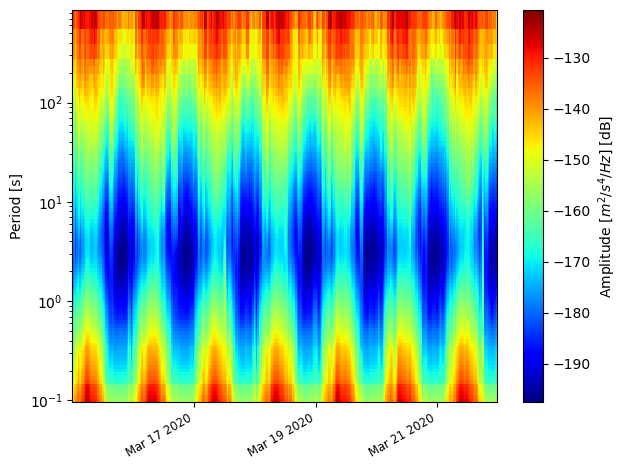

In [124]:
# plot spectrogram with original plot_spectrogram from obspy

example.plot_spectrogram(grid=False, cmap='jet');

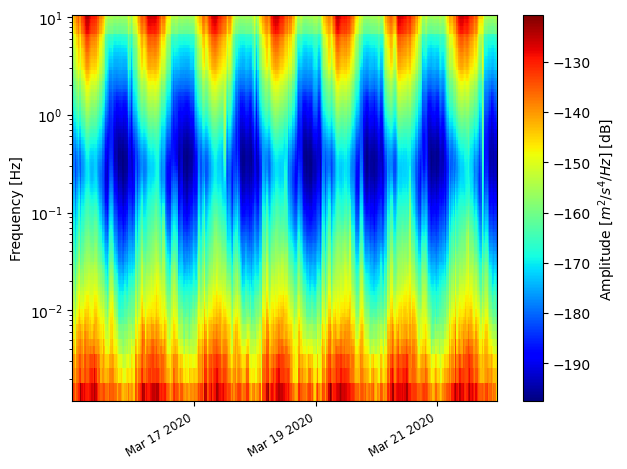

In [125]:
# plotting reversed spectrogram with plot_spectrogram2 function

plot_spectrogram2(example, grid=False, cmap='jet');

(array([ 8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24,
       25, 26, 27, 28, 29], dtype=int64),)


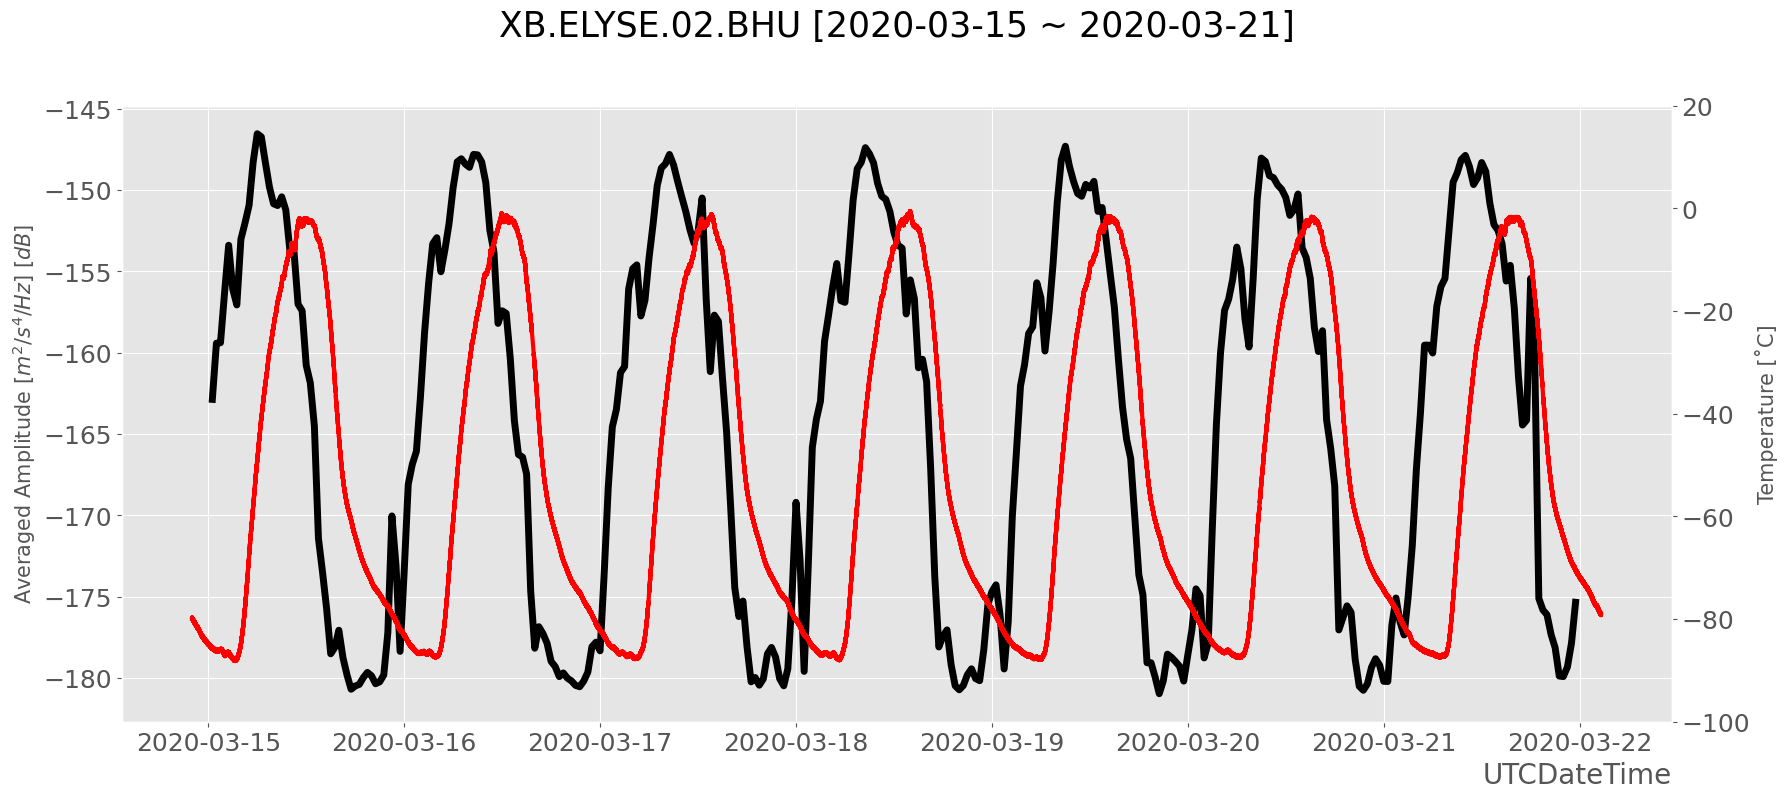

In [127]:
# Diurnal variation of averaged amplitude with each 1-hour windows 

import seaborn as sns
import matplotlib.dates as mdates
from datetime import *

fre = example.get_percentile()[0]

freq = np.where((fre < 1 / 0.8) & (fre > 1 / 5.0))
print(freq)


avg_amplitude = []
time = []

utc_datetimes = [datetime(2020, 3, 15, 0, 0) + timedelta(hours=i) for i in range(24*7)]
mars_lmst = [timedelta(hours=24, minutes=39, seconds=37) * i for i in range(24*7)]

for i in range(len(example.psd_values)):
    time.append(UTCDateTime(int(str(example._times_processed[i])[:10]) + 60*30 ).matplotlib_date)
    avg_amplitude.append(example.psd_values[i][8:29].mean())


fig, ax = plt.subplots(figsize = (20, 8))
ax2 = ax.twinx()

plt.style.use(['ggplot'])

line1 = ax.plot(time, avg_amplitude, linewidth = 5, color= 'black', label = 'Averaged Amplitude')
line2 = ax2.plot(df.UTC, df.BMY_BASE_ROD_TEMP, linewidth = 3, color = 'red', label = 'Temperature')
ax.tick_params(axis='both', which='major', labelsize=18)
ax2.tick_params(axis='both', which='major', labelsize=18)
#ax.set_xticks()

ax.set_xlabel('UTCDateTime', size = 20, loc='right')
ax.set_ylabel('Averaged Amplitude [$m^2 / s^4 / Hz$] [$dB$]', size = 15)
ax2.set_ylabel('Temperature [˚C]', size = 15)
ax.set_title('XB.ELYSE.02.BHU [2020-03-15 ~ 2020-03-21]', size = 25, pad = 50)
ax2.set_xlim(ax.get_xlim())
ax2.set_ylim(-100, 20)

ax.grid(True)
ax2.grid(False)
'''
lines = line1 + line2
labels = [l.get_label() for l in lines]
ax.legend(lines, labels, loc='upper right')
'''
xfmt = mdates.DateFormatter('%Y-%m-%d')
ax.xaxis.set_major_formatter(xfmt)
#ax.xaxis.set_minor_locator(AutoMinorLocator(4))

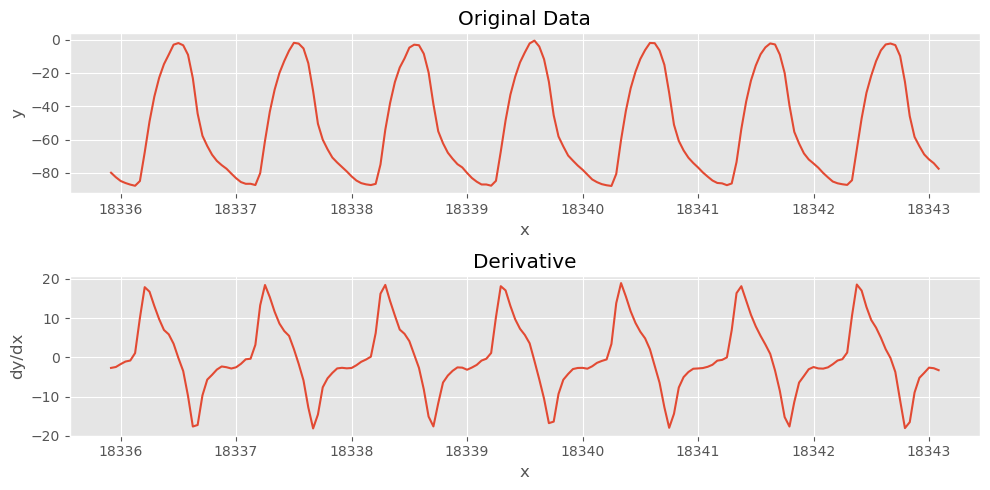

In [128]:
x = df.UTC[::3600].values
y = df.BMY_BASE_ROD_TEMP[::3600].values
dx = np.gradient(y)
dy_dx = np.gradient(y, dx)

plt.figure(figsize=(10, 5))
plt.subplot(2, 1, 1)
plt.plot(x, y, label='Original Data')
plt.title('Original Data')
plt.xlabel('x')
plt.ylabel('y')

plt.subplot(2, 1, 2)
plt.plot(x, dx, label='Derivative')
plt.title('Derivative')
plt.xlabel('x')
plt.ylabel('dy/dx')

plt.tight_layout()
plt.show()

(array([ 8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24,
       25, 26, 27, 28, 29], dtype=int64),)


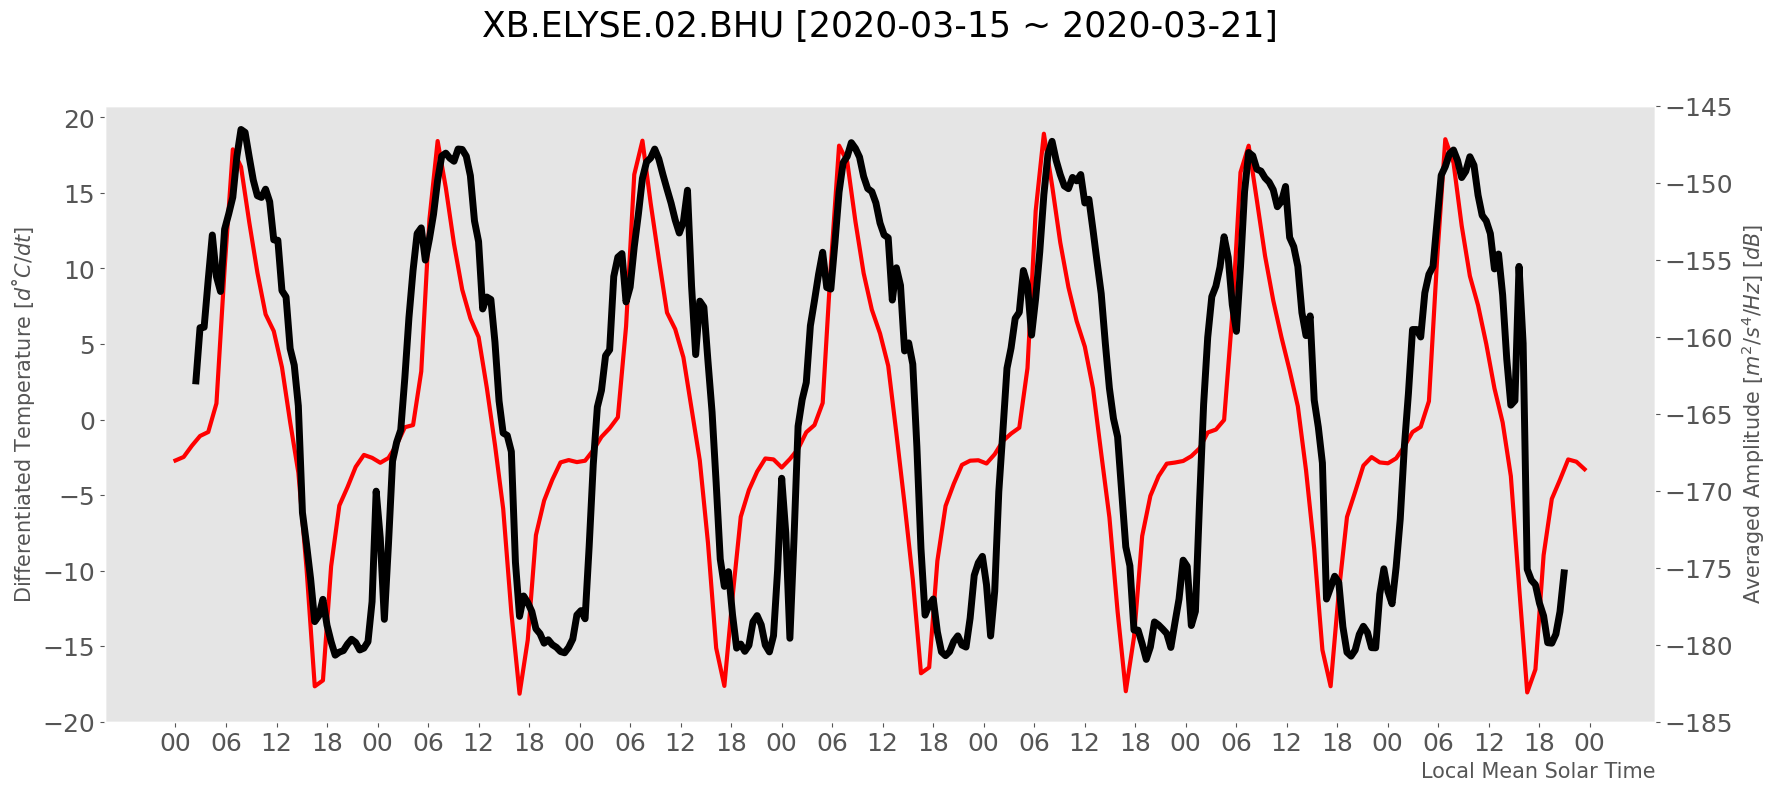

In [129]:
# Diurnal variation of averaged amplitude with each 1-hour windows 

import seaborn as sns
import matplotlib.dates as mdates
from datetime import *

fre = example.get_percentile()[0]

freq = np.where((fre < 1 / 0.8) & (fre > 1 / 5.0))
print(freq)

avg_amplitude = []
time = []

for i in range(len(example.psd_values)):
    time.append(UTCDateTime(int(str(example._times_processed[i])[:10]) + 60*30 ).matplotlib_date)
    avg_amplitude.append(example.psd_values[i][8:29].mean())

fig, ax = plt.subplots(figsize = (20, 8))
ax2 = ax.twinx()


plt.style.use(['ggplot'])

#line1 = ax.plot(df.UTC, df.BMY_BASE_ROD_TEMP, linewidth = 5, color = 'red', label = 'Temperature', visible = False)
line1 = ax.plot(x, dx, linewidth = 3, color= 'red', label='Differentiated Temperature', visible = True)
line2 = ax2.plot(time, avg_amplitude, linewidth = 5, color= 'black', label = 'Averaged Amplitude', visible = True)
#line3 = ax3.plot(x, dx, linewidth = 3, color= 'red', label='Derivative')
#ax4.plot(df.UTC[::500], df.BMY_HORIZONTAL_WIND_SPEED[::500], linewidth = 1, color = 'blue', label = 'Horizontal Wind speed')

ax.tick_params(axis='both', which='major', labelsize=18)
#ax.tick_params(axis='both', which='minor', labelsize=18)
ax2.tick_params(axis='both', which='major', labelsize=18)

ax.set_xlabel('Local Mean Solar Time', size = 15, loc='right')
ax.set_ylabel('Differentiated Temperature [$d ˚C / d t$]', size = 15)
ax2.set_ylabel('Averaged Amplitude [$m^2 / s^4 / Hz$] [$dB$]', size = 15)
ax.set_title('XB.ELYSE.02.BHU [2020-03-15 ~ 2020-03-21]', size = 25, pad = 50)
ax2.set_xlim(ax.get_xlim())
#ax.set_ylim(-90, 0)
ax2.set_ylim(-185, -145)
ax2.set_xticks([df.UTC[0], df.UTC[22194], df.UTC[44398], df.UTC[66582], df.UTC[88777], df.UTC[110971], df.UTC[133165], 
               df.UTC[155359],df.UTC[177553],df.UTC[199747],df.UTC[221941],df.UTC[244135],df.UTC[266329],df.UTC[288523],
               df.UTC[310717],df.UTC[332911],df.UTC[355105],df.UTC[377299],df.UTC[399493],df.UTC[421687],df.UTC[443881],
               df.UTC[466075],df.UTC[488269],df.UTC[510463],df.UTC[532657],df.UTC[554851],df.UTC[577045],df.UTC[577045+22194], df.UTC[621436]])
ax2.set_xticklabels(['00', '06', '12', '18','00', '06', '12', '18','00', '06', '12', '18','00', '06', '12', '18','00', '06', '12', '18','00', '06', '12', '18','00', '06', '12', '18', '00'], fontsize = 15)
ax2.set_yticks([-185, -180, -175, -170, -165, -160, -155, -150, -145])
#ax.set_yticks([-195, -190, -185, -180, -175, -170, -165, -160])
plt.gca().axes.yaxis.set_visible(True)

ax.grid(False)
ax2.grid(False)
#ax3.grid(False)


---

In [ ]:
# Diurnal variation of averaged amplitude with each 1-hour windows 

import seaborn as sns
import matplotlib.dates as mdates

fre = example.get_percentile()[0]
freq = np.where((fre < 1 / 0.8) & (fre > 1 / 5.0))
print(freq)

avg_amplitude = []
time = []

for i in range(len(example.psd_values)):
    time.append(UTCDateTime(int(str(example._times_processed[i])[:10])).matplotlib_date)
    avg_amplitude.append(np.median(example.psd_values[i][8:29]))

fig, ax = plt.subplots(figsize = (15, 8))
plt.style.use(['bmh'])

ax.plot(time, avg_amplitude, marker ='o')
ax.set_xlabel('UTCDateTime')
ax.set_ylabel('Averaged Amplitude [$m^2 / s^4 / Hz$] [$dB$]')
ax.set_title('XB.ELYSE.02.BHU [2020-01-01 ~ 2021-01-01]')
ax.set_xlim(18262, 18262+1000)

xfmt = mdates.DateFormatter('%Y-%m-%d')
ax.xaxis.set_major_formatter(xfmt)

In [ ]:
# Compute the Discrete Fourier Transform
dft = np.fft.rfft(avg_amplitude)
freqs = np.fft.rfftfreq(len(avg_amplitude), d=time[1]-time[0])

plt.figure(figsize=(10, 6))
plt.plot(1/freqs, np.abs(dft))
plt.title('Period (DFT)')
plt.xlabel('Period (day)')
plt.ylabel('PSD')
plt.xticks([0.25, 0.50, 0.75, 1.00, 1.25, 1.50, 1.75, 2.00])
plt.xlim(0, 2.0)
plt.grid(True)
plt.show()

In [ ]:
# Diurnal variation of averaged amplitude with each 1-hour windows 

import seaborn as sns
import matplotlib.dates as mdates

fre = example.get_percentile()[0]

freq = np.where((fre < 1 / 0.8) & (fre > 1 / 5.0))
print(freq)


avg_amplitude = []
time = []

for i in range(len(example.psd_values)):
    time.append(UTCDateTime(int(str(example._times_processed[i])[:10]) + 60*30).matplotlib_date)
    avg_amplitude.append(example.psd_values[i].max())

fig, ax = plt.subplots(figsize = (20, 8))
ax2 = ax.twinx()
ax3 = ax.twiny()

plt.style.use(['ggplot'])

line1 = ax.plot(time, avg_amplitude, linewidth = 5, color= 'black', label = 'Averaged Amplitude')
line2 = ax2.plot(df.UTC, df.BMY_HORIZONTAL_WIND_SPEED, linewidth = 1, color = 'blue', label = 'Horizontal Wind speed')
ax.tick_params(axis='both', which='major', labelsize=18)
ax2.tick_params(axis='both', which='major', labelsize=18)
ax.set_xlabel('UTCDateTime', size = 20)
ax.set_ylabel('Averaged Amplitude [$m^2 / s^4 / Hz$] [$dB$]', size = 15)
ax2.set_ylabel('Wind horizontal speed [m/s]', size = 15)
ax.set_title('XB.ELYSE.02.BHU [2020-03-15 ~ 2020-03-21]', size = 25)
#ax.set_ylim(-195, -150)

ax.grid(False)
ax2.grid(False)

lines = line1 + line2
labels = [l.get_label() for l in lines]
ax.legend(lines, labels, loc='upper right')

xfmt = mdates.DateFormatter('%Y-%m-%d')
ax.xaxis.set_major_formatter(xfmt)
